## NYC taxi uber/lyft workflow

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import dask
dask.utils.show_versions()

{
  "Python": "3.11.0",
  "Platform": "Darwin",
  "dask": "2023.3.2",
  "distributed": "2023.3.2",
  "numpy": "1.23.5",
  "pandas": "2.0.0",
  "cloudpickle": "2.2.1",
  "fsspec": "2023.3.0",
  "bokeh": "2.4.3",
  "fastparquet": null,
  "pyarrow": "11.0.0",
  "zarr": null
}

In [3]:
import pandas as pd
import numpy as np
from dask.sizeof import sizeof
from dask.utils import format_bytes
from dask import delayed
from dask.distributed import PipInstall, PackageInstall
import dask.dataframe as dd
import random
import string
from distributed import wait
from distributed import Client
from distributed.diagnostics import MemorySampler
import coiled
import matplotlib
import matplotlib.pyplot as plt

In [4]:
import crick

In [5]:
from dask.distributed import performance_report

In [6]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
cluster

LocalCluster(d5895bf4, 'tcp://127.0.0.1:54791', workers=4, threads=12, memory=64.00 GiB)

In [7]:
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54791,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:54802,Total threads: 3
Dashboard: http://127.0.0.1:54807/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:54794,


In [8]:
file_paths = [
    f"s3://coiled-datasets/mrocklin/nyc-taxi-fhv/{year}-02*.parquet"
    for year in range(2019, 2020)
]
file_paths

['s3://coiled-datasets/mrocklin/nyc-taxi-fhv/2019-02*.parquet']

In [9]:
def get_ddf(persist=False):
    columns = [
        "hvfhs_license_num",
        "tips",
        "base_passenger_fare",
        "driver_pay",
        "trip_miles",
        "trip_time",
        "shared_request_flag",
    ]
    with dask.config.set({"dataframe.convert_string": True}):
        ddf = dd.read_parquet(file_paths, columns=columns)
        return ddf.persist() if persist else ddf

In [10]:
client.restart();

2023-04-07 10:24:34,844 - distributed.nanny - WARNING - Restarting worker
2023-04-07 10:24:34,852 - distributed.nanny - WARNING - Restarting worker
2023-04-07 10:24:34,854 - distributed.nanny - WARNING - Restarting worker
2023-04-07 10:24:34,854 - distributed.nanny - WARNING - Restarting worker


In [11]:
ddf = get_ddf()

In [12]:
taxi_companies = {
    "HV0002": "Juno",
    "HV0003": "Uber",
    "HV0004": "Via",
    "HV0005": "Lyft"
}

In [13]:
ddf["company"] = ddf.hvfhs_license_num.replace(taxi_companies)

In [14]:
# add a column to indicate that tip was given
ddf["tip_flag"] = ddf.tips > 0

In [15]:
# what percentage of fare is the tip
ddf["tip_percentage"] = ddf.tips / ddf.base_passenger_fare

In [16]:
ddf = ddf.persist()

In [17]:
ddf.dtypes

hvfhs_license_num      string[pyarrow]
tips                           float32
base_passenger_fare            float32
driver_pay                     float32
trip_miles                     float32
trip_time                        int32
shared_request_flag           category
company                string[pyarrow]
tip_flag                          bool
tip_percentage                 float32
dtype: object

Calculate how many passengers tip:

In [18]:
%%time

tipped = (ddf.tips != 0).mean().compute()

CPU times: user 1.04 s, sys: 245 ms, total: 1.29 s
Wall time: 14 s


In [19]:
tipped

0.13724178036144266

In [20]:
%%time
tipped_counts = ddf.groupby("company").tip_flag.value_counts().compute()

CPU times: user 39.2 ms, sys: 6.57 ms, total: 45.8 ms
Wall time: 204 ms


In [21]:
tipped_counts = tipped_counts.unstack().reset_index()
tipped_counts

tip_flag,company,False,True
0,Juno,899689,79538
1,Lyft,3732492,959003
2,Uber,11882476,1622410
3,Via,784301,90851


In [22]:
tipped_counts["tipped_ratio"] = tipped_counts[True] / (tipped_counts[False] + tipped_counts[True])
tipped_counts

tip_flag,company,False,True,tipped_ratio
0,Juno,899689,79538,0.081225
1,Lyft,3732492,959003,0.204413
2,Uber,11882476,1622410,0.120135
3,Via,784301,90851,0.103812


<Axes: xlabel='company'>

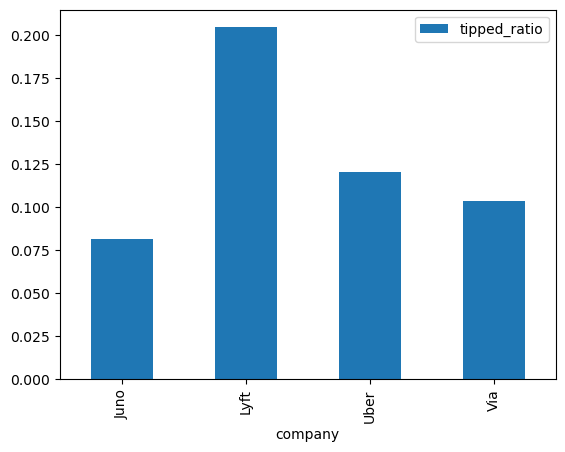

In [23]:
tipped_counts.plot(x="company", y="tipped_ratio", kind="bar")

In [24]:
# what's the largest and average pay and tips that driver got, by company
ddf.groupby("company").agg(
    {"driver_pay": ["max", "mean"], "tips": ["max", "mean"]}
).compute()

driver_pay                   tips          
                max       mean         max      mean
company                                             
Uber     857.719971  15.500295  100.000000  0.414673
Lyft     561.429993  11.724117   50.000000  0.798096
Juno     524.270020  13.792146  400.000000  0.281309
Via       87.309998   0.392115   99.989998  0.166254

In [25]:
# tip percentage mean of trip with tip
ddf.loc[lambda x: x.tip_flag].groupby("company").tip_percentage.mean().compute()

company
Juno    0.211522
Lyft    0.232923
Uber    0.000000
Via     0.189957
Name: tip_percentage, dtype: float64

In [26]:
df_tiny = (
    ddf.loc[lambda x: x.tip_flag][["trip_miles", "base_passenger_fare", "tips"]]
    .sample(frac=0.001)
    .compute()
)

In [27]:
df_tiny

,trip_miles,base_passenger_fare,tips
request_datetime,,,
2019-02-01 21:51:43,1.62,6.050000,1.00
2019-02-01 05:23:20,2.10,7.180000,2.00
2019-02-01 17:32:38,1.31,8.480000,2.00
2019-02-01 23:07:14,9.41,8.040000,2.00
2019-02-01 02:46:54,17.15,45.529999,6.14
...,...,...,...
2019-02-28 15:34:14,0.97,7.690000,5.00
2019-02-28 12:05:17,1.68,9.840000,2.00
2019-02-28 20:37:14,4.10,9.600000,1.00


In [28]:
tips_filter_vals = df_tiny.tips.quantile([0.25, 0.75]).values

In [29]:
fare_filter_vals = df_tiny.base_passenger_fare.quantile([0.25, 0.75]).values

In [30]:
miles_filter_vals = df_tiny.trip_miles.quantile([0.25, 0.75]).values

In [31]:
tips_filter_vals

array([2., 5.])

In [32]:
fare_filter_vals

array([ 7.69000006, 24.42000008])

In [33]:
miles_filter_vals

array([1.65999997, 6.90999985])

In [37]:
# quantile with dask, to compare
ddf.tips.quantile([0.25, 0.75], method="tdigest").values.compute()

array([0., 0.])

In [38]:
# quantile with dask, to compare
ddf.base_passenger_fare.quantile([0.25, 0.75], method="tdigest").values.compute()

array([ 6.73164496, 19.03099679])

In [39]:
# quantile with dask, to compare
ddf.trip_miles.quantile([0.25, 0.75]).values.compute()

array([1.74000001, 6.21000004])

In [40]:
# filter outliers by tips values
tips_condition = ddf.tips.between(*tips_filter_vals)

# filter outliers by fare values
fares_condition = ddf.base_passenger_fare.between(*fare_filter_vals)

# filter outliers by miles values
miles_condition = ddf.trip_miles.between(*miles_filter_vals)

In [41]:
# filter the dataset to remove outliers, and persist again
ddf = ddf.loc[(tips_condition & fares_condition) & miles_condition].persist()

In [42]:
# now compute tip stats again
ddf.groupby("company").tip_percentage.mean().compute()

company
Juno    0.204384
Lyft    0.216943
Uber    0.216223
Via     0.204226
Name: tip_percentage, dtype: float64

In [44]:
# average trip time by provider
ddf.groupby("company").trip_time.agg(
    ["min", "max", "mean", "std"]
).compute()

,min,max,mean,std
company,,,,
Lyft,0,5460,1008.666940,1079.141007
Uber,198,9854,1072.669058,1143.668767
Juno,313,3290,1040.093827,1091.467810
Via,268,7748,1524.720772,1630.455216


In [47]:
# ride count per company
ddf.company.value_counts().compute()

company
Uber    388177
Lyft    327238
Juno     25110
Via       7664
Name: count, dtype: int64[pyarrow]

In [48]:
client.close()

In [49]:
cluster.close()